In [1]:
import pandas as pd
import numpy as np
import pytraj as pyt
import csv
import ast
import datetime
import matplotlib.pyplot as plt
from modulos.MDS import cMDS, plot_mds_or_pca

/home/joel/anaconda3/envs/mds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
df_cdk2 = pd.read_csv("./B_DATOS/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO.csv", index_col = 0,
                     converters={"NameLigs": lambda x: ast.literal_eval(x),
                                "GapPos": lambda x: ast.literal_eval(x),
                                 "Date": lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d")),
                                 "NameLigs": lambda x: ast.literal_eval(x),
                                })
df_cdk2.set_index("PDB_ID", inplace=True)
df_cdk2.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
PDB_ID,,,,,,,,,,,,,,
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,['STU'],STU,440.0
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0


In [3]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = "../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/PDB_402_cdk2_PISANI_ALL.pdb"
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 4848.


In [4]:
# Función para etiquetar cada estructura
from modulos.label_cdk2_confs import label_cdk2_conformations
labels_cdk2 = label_cdk2_conformations(traj_crystals)
df_cdk2["Labels_conf"] = labels_cdk2
df_cdk2.head(5)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf
PDB_ID,,,,,,,,,,,,,,,
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298.0,92.953020,2.0,"[8, 13]","[[36, 43], [149, 161]]",1.0,['STU'],STU,440.0,inact_b
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298.0,97.315436,1.0,[8],"[[36, 43]]",3.0,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298.0,96.308725,2.0,"[7, 4]","[[40, 46], [295, 298]]",0.0,[],NaN,NaN,inact_a
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298.0,93.624161,2.0,"[8, 11]","[[36, 43], [153, 163]]",2.0,"['EDO', 'PVB']",PVB,214.0,inact_a


In [5]:
from modulos.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",") # subsecuencia de la estructura secuendaria
pocket_residues = get_pocket_residues(sep=",")

In [6]:
# Filtrado de las estructuras
# Primera condición
res_25_A_o_menos = df_cdk2.Resolution <= 2.5

# Segunda condición
from modulos.find_gaps import is_a_gap
no_gaps_en_seq = df_cdk2.GapPos.apply( lambda x: is_a_gap(x, get_pisani_residues(x="list")) )

# Tercera condición: ¿Cuántas y cuáles de las estructuras se publicaron como máximo hasta 2015?
fecha_2015_o_menos = df_cdk2.Date.apply(lambda x:  x.year  <= 2015)

# Obtenemos los índices resultantes
frames_pisani = np.array((res_25_A_o_menos) & (no_gaps_en_seq) & (fecha_2015_o_menos))

In [7]:
# RMSD por pares de las 402 estructuras
pair_rmsd_402_struc = pyt.pairwise_rmsd( traj = traj_crystals, mask= F"(:{pisiani_residues})&(@CA)", metric="rmsd")

# Subset de RMSD por pares usando sólo sus 255 estructuras
pair_rmsd_pisani = pair_rmsd_402_struc[:, frames_pisani][frames_pisani, :]

In [8]:
pair_rmsd_402_struc.shape

(402, 402)

In [9]:
# MDS, usamos la función que previamente habíamos definido en moduloes.cMDS
mds_pisani = cMDS(pair_rmsd_pisani)

mds_total = cMDS(pair_rmsd_402_struc)

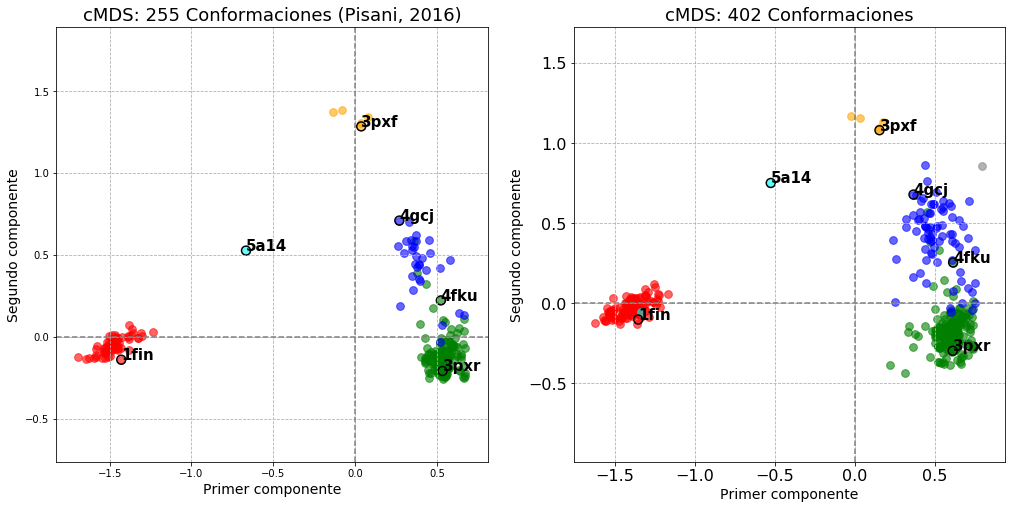

In [10]:
# Estructuras de  referencia que queremos mostrar en la gráfica
ref_structs_dict = {"1fin": "red", "5a14": "cyan", "3pxr": "green", "4gcj": "blue", "3pxf": "orange", "4fku": "purple"}
# Etiquetas según el PDB ID de cada estructura
traj_labels_pisani = df_cdk2.index[frames_pisani]
# Se genera la gráfica
fig = plt.figure(figsize=(17, 8))
plt.subplot(1, 2, 1)
plot_mds_or_pca(mds = mds_pisani[0], labels = df_cdk2.Labels_conf[frames_pisani],
                dic_of_ref_labels = ref_structs_dict, traj_labels = traj_labels_pisani,
                             title = "cMDS: 255 Conformaciones (Pisani, 2016)")
 
plt.subplot(1, 2, 2)
plot_mds_or_pca(mds = mds_total[0], labels = df_cdk2.Labels_conf,
                dic_of_ref_labels = ref_structs_dict, traj_labels = df_cdk2.index,
                             title = "cMDS: 402 Conformaciones")

## Cargamos la nueva trayectoria

In [11]:
path_dinamicas = "../ARCHIVOS/DINAMICA/"

In [12]:
# Carga de la trayectoria de las estructuras cristalográficas
file_pdb_traj_pisani = "../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/PDB_402_cdk2_PISANI_ALL.pdb"
traj_crystals_mda = pyt.load(file_pdb_traj_pisani, mask ="@CA")

In [13]:
# Tryectoria de dinámica molecular
# 1fin SA_DM
file_mxs_1fin_r1 = path_dinamicas + "1fin/mxs_sa/rep_1/"
traj_mxs_1fin_r1 = pyt.load( top = file_mxs_1fin_r1 + "mxs_1fin.prmtop", 
                            filename = file_mxs_1fin_r1 + "4_prod/" + "mxs_1fin_prod.nc", mask ="@CA")

In [14]:
# Se juntan ambas trayectorias
new_traj = pyt.Trajectory(traj_crystals_mda)
new_traj.append_xyz(traj_mxs_1fin_r1.xyz)

# Se calcula la matriz de disimilitud
pyt.align(new_traj, F"(:{pisiani_residues})&(@CA)", ref=0)
m = pyt.pairwise_rmsd(new_traj, mask= F"(:{pisiani_residues})&(@CA)", metric="rmsd")

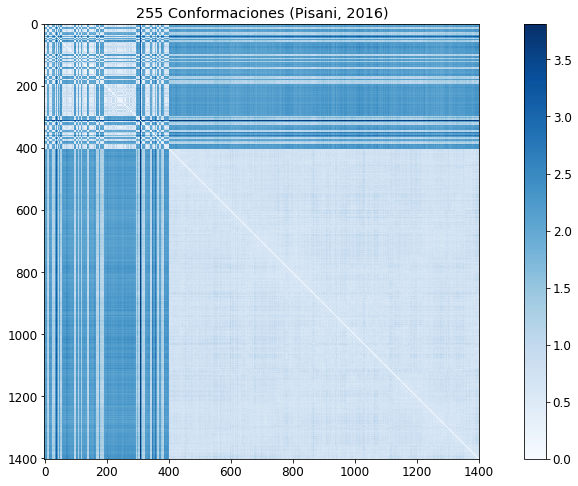

In [15]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 12})
plt.title("255 Conformaciones (Pisani, 2016)")
plt.imshow(m, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [16]:
traj_disimilitud = m[ 402:, :402 ]

In [17]:
from modulos.MDS import cMDS_proj

In [18]:
b = cMDS_proj(mds_total, traj_disimilitud[:])
b.shape

(1000, 361)

In [25]:
def density_estimation(m1, m2):
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

In [37]:
from scipy.stats import gaussian_kde
xy = np.vstack([b[:, 0], b[:, 1]])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = b[:, 0][idx], b[:, 1][idx], z[idx]

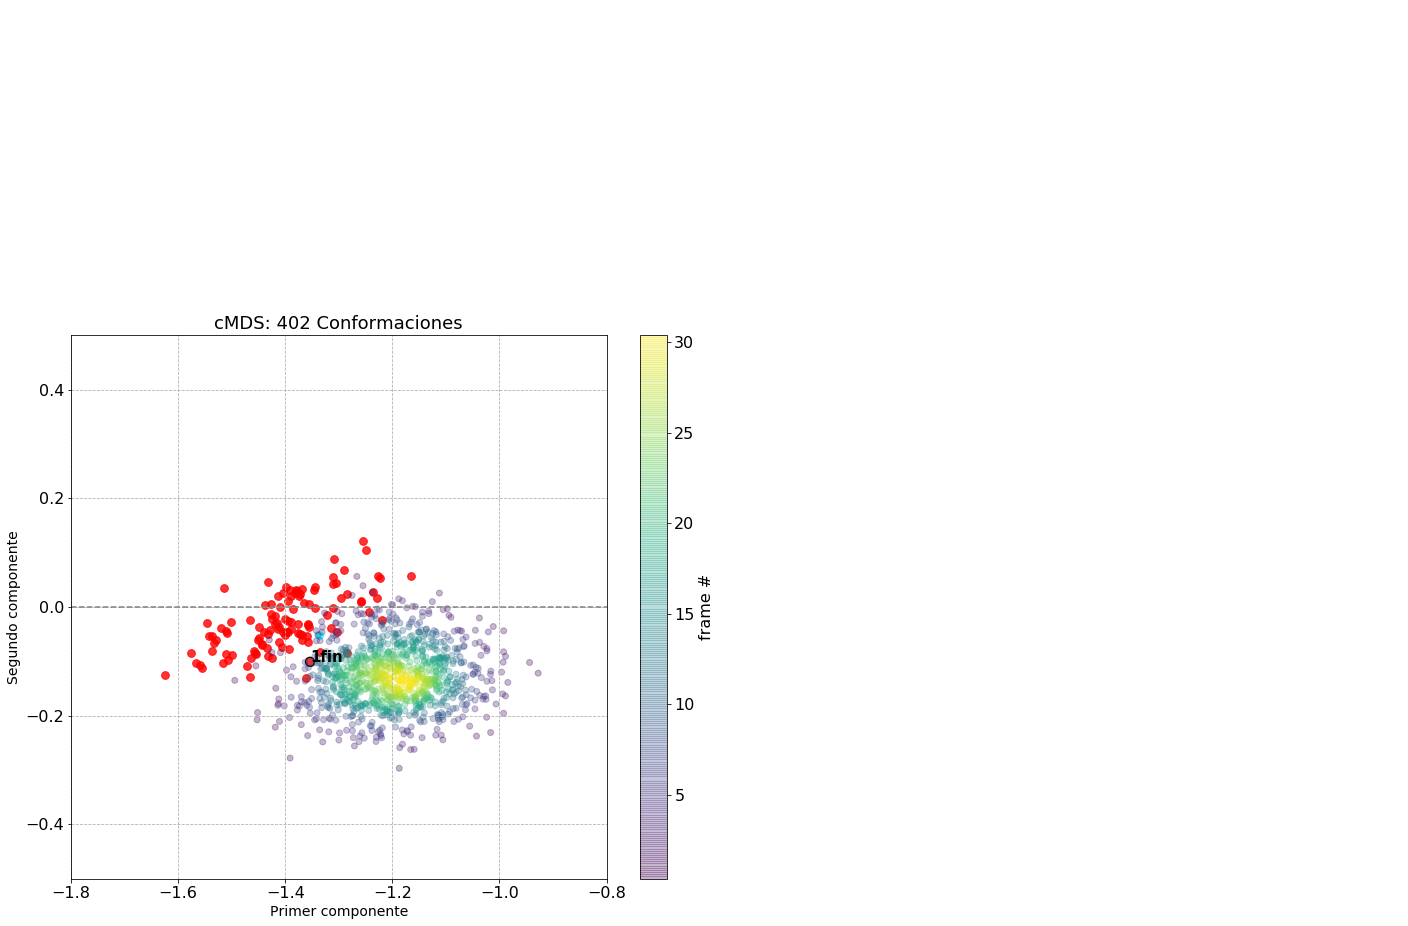

In [39]:
fig = plt.figure(figsize=(12, 10))
plot_mds_or_pca(mds = mds_total[0], labels = df_cdk2.Labels_conf,
                dic_of_ref_labels = ref_structs_dict, traj_labels = df_cdk2.index,
                             title = "cMDS: 402 Conformaciones", alpha = 0.8, xy_lims=[-1.8, -0.8, -0.5, 0.5], equal_axis=False)
plt.scatter(x= x, y = y, c = z, alpha = 0.3)

cbar = plt.colorbar()
cbar.set_label('frame #');